# devlog 2024-02-13

_Author: Tyler Coles_

Demonstration of how to use the new movement data collection feature to examine the operation of a movement model.

## What data is there to collect?

The execution of the movement model is really answering two questions every time a movement clause fires:

1) how many individuals (regardless of IPM state) were _requested_ to move from every node to every other node, and
2) how many individuals (divided by IPM state) were _actually_ moved from every node to every other node.

The total number of individuals involved in these two answers can vary, especially if there were not enough individuals in a source node to satisfy the requested movement.

Requested movement (for user-defined clauses) is the direct result of the movement clause function. Return movement is done internally by epymorph, so the "return clause" is virtual, in a sense, though its data is also captured by this mechanism.

In movement execution, the requested movement is converted into actual movement by performing random draws on the individuals present in a location. For example, if we request 100 people to move, we might choose 75 Susceptibles, 20 Infectious, and 5 Recovered (in an SIR model). If there are less than 100 people in that location, we will choose all of them, whichever IPM state they are in.

## How do we collect movement data?

If we run our simulation in a `movement_data` context, it will provide us a `MovementData` object which we can use to access both _requested_ and _actual_ movement flows by clause name or in total.

Let's see an example: first we'll set up a simulation using the "centroids" movement model, then run it to collect movement data, and finally inspect the collected data to give you an idea of what you can do with it.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pygris as pg

from epymorph import *
from epymorph.geo.cache import load_from_cache
from epymorph.geo.geo import Geo
from epymorph.log.movement import movement_data

In [2]:
def load_geo(name: str) -> Geo:
    cached = load_from_cache(name)
    if not cached is None:
        return cached
    else:
        return geo_library[name]()


geo = load_geo("us_sw_counties_2015")
ipm = ipm_library["sirs"]()
mm = mm_library["centroids"]()

rume = Rume.single_strata(
    ipm=ipm,
    mm=mm,
    init=init.SingleLocation(location=0, seed_size=1_000),
    scope=geo.spec.scope,
    time_frame=TimeFrame.of("2015-01-01", 100),
    params={
        "phi": 40.0,
        "beta": 0.4,
        "gamma": 1 / 5,
        "xi": 1 / 90,
        "population": geo["population"],
        "centroid": geo["centroid"],
    },
)

# Python lets us run code in a block with multiple context managers,
# so we'll do both the console messaging and collection of movement data.
# The `move_data` object returned by the movement_data context is where
# the movement data will be collected.
# NOTE: we should only access its data _after_ the context completes.
sim = BasicSimulator(rume)
with (
    sim_messaging(sim, True),
    movement_data(sim) as move_data,
):
    out = sim.run(rng_factory=default_rng(42))

# Now we're free to use `move_data`.

Running simulation (BasicSimulator):
• 2015-01-01 to 2015-04-11 (100 days)
• 158 geo nodes
|####################| 100% 
Runtime: 6.442s


## Data Analysis

1. Which counties "exported" the most infectious cases?

To find out, we can sum all "I" individuals leaving each node across the whole time series. There's only one clause that is responsible for people leaving their home county, and that's "centroids_commuters", so we focus just on the actual movement from that clause.

In [3]:
# Get actual commuters movement flows
commuters = move_data.actual_by("centroids_commuters")

# Select just the Infectious compartment
# NOTE: `compartments_by` returns a tuple, so this result still has 4 axes; we'll deal with it in the next step.
commuters_I = commuters[:, :, :, ipm.compartments_by("I")]

# Compute the totals leaving each source node, regardless of destination node, and across time.
exported_I = commuters_I.sum(axis=(0, 2, 3))

# `argsort` gives us the indices that would sort the array, so we can use this to subselect.
# Sort the negative of the array to get descending order.
top_ten = np.argsort(-exported_I)[0:10]

# Chart of the top 10 "exporters"
# I think we can safely say the units for the exported column are "people-days",
# since each individual is counted every time they commute as long as they are infectious,
# but we know from the movement mechanics that they will only commute up to once per day.
# It's a little esoteric, but gives us a basis for comparison.
pd.DataFrame(
    {
        "label": geo.labels[top_ten],
        "exported": exported_I[top_ten],
    }
)

,label,exported
0,"Maricopa County, Arizona",943604
1,"Clark County, Nevada",704968
2,"Denver County, Colorado",189615
3,"Salt Lake County, Utah",187435
4,"Bernalillo County, New Mexico",183298
5,"Jefferson County, Colorado",150312
6,"El Paso County, Colorado",133019
7,"Arapahoe County, Colorado",123202
8,"Washoe County, Nevada",122900
9,"Pinal County, Arizona",114149


2. Let's draw a map.

That isn't a question, but sure! Maybe we'd like to see which counties exported the most infectious person-days relative to the total person-days they exported.

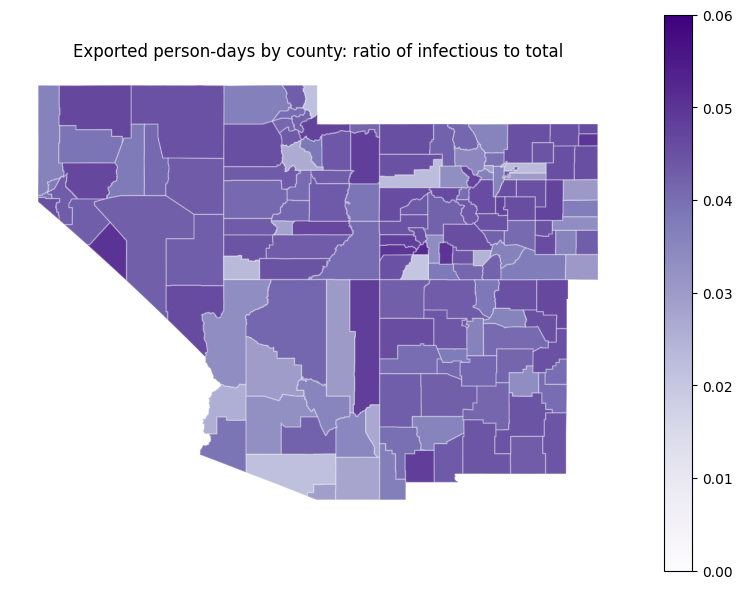

In [4]:
commuters = move_data.actual_by("centroids_commuters")

df = pd.DataFrame(
    {
        "GEOID": geo["geoid"],
        "I": commuters[..., ipm.compartments_by("I")].sum(axis=(0, 2, 3)),
        "N": commuters.sum(axis=(0, 2, 3)),
    }
)
df["I:N"] = df["I"] / df["N"]

gdf_counties = pg.counties(cb=True, resolution="5m", cache=True, year=2020)

gdf = pd.merge(
    on="GEOID",
    how="right",
    left=gdf_counties[["GEOID", "geometry"]],
    right=df,
)

fig, ax = plt.subplots(figsize=(8, 6))
ax.axis("off")
ax.set_title("Exported person-days by county: ratio of infectious to total")
gdf.plot(ax=ax, column="I:N", cmap="Purples", legend=True, vmin=0, vmax=0.06)
gdf.plot(ax=ax, color="none", edgecolor="white", linewidth=1, alpha=0.2)
fig.tight_layout()
plt.show()

3. When are the most infectious individuals moving around?

We could certainly sum across the geography and look at time-series data. This time we'll lump commuting movement and returning movement together -- we're interested in how many infectious individuals are moving even if they catch the infection "at work" and bring it home. Again, the units of this aren't easily applicable, but the magnitude is all we need for a comparison.

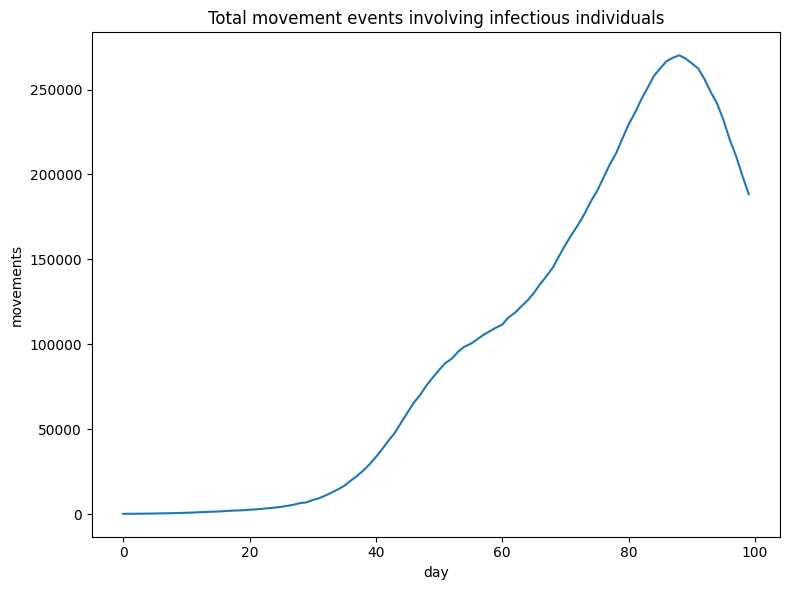

In [5]:
movers = move_data.actual_all()

T, N, _, E = out.dim.TNCE
D = out.dim.days
taus = out.dim.tau_steps

# Select infected movers and sum by simulation tick
movers_I = movers[..., ipm.compartments_by("I")].sum(axis=(1, 2, 3))

# Then we group-and-sum to get a daily total
movers_I_per_day = movers_I.reshape((T // taus, taus)).sum(axis=1)

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title("Total movement events involving infectious individuals")
ax.set_xlabel("day")
ax.set_ylabel("movements")
ax.plot(np.arange(D), movers_I_per_day)
fig.tight_layout()
plt.show()

4. How can we check that everyone who leaves due to the commuters clause returns home at the end of the day, like we expect?

In other words: how do we know the centroids movement model works?

In [6]:
# Commuters should be leaving their homes at the start of the day-time tau-step (tau-0)...
commuters = move_data.actual_by("centroids_commuters")
# And returning home at the end of the day (aka, the start of the night-time tau-step; tau-1).
returners = move_data.actual_by("return")

# There are no other clauses in this movement model to worry about,
# but more complicated models may not be as easy as this to analyze.

# Compare tau-0 to tau-1 for every day in the sim:
for t in range(0, out.dim.ticks, 2):
    # Sum commuters by source node,
    a = commuters[t + 0].sum(axis=(1, 2))
    # But sum returners by destination node!
    b = returners[t + 1].sum(axis=(0, 2))
    # This way we're correctly comparing everyone who left with everyone who came back.

    # I use the sum here because the returners might not have the exact same IPM state distribution
    # as when they left; the IPM execution may have transitioned some of them to different states.
    # Only the count of individuals can be guaranteed to be the same.

    # We've found an error if there are any differences between `a` and `b`.
    if not np.array_equal(a, b):
        print(f"not equal at {t}")
        break
else:
    # Otherwise, no errors means success!
    print("all equal!")

all equal!
